In [1]:
# Import packages needed
import pandas as pd
import datetime as dt
import yfinance as yf
import numpy as np
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
#Download of Data from yfinance

start_date = dt.datetime.today()- dt.timedelta(8000) 
end_date = dt.datetime.today()
stock ="EURUSD=X"
data = yf.download(stock, start_date, end_date)[['Adj Close']]

[*********************100%***********************]  1 of 1 completed


In [3]:
#Import data into dataframe
df = pd.DataFrame(data)

#Converting Index into Datetime type
df.index = pd.DatetimeIndex(df.index).to_period('D')

# Resample data to fill in missing dates with last closing prices
df = df.resample('D').mean().fillna(method="ffill")

# Rename Columns to that of security
df.rename(columns={"Adj Close":stock}, inplace=True)

# convert Dataframe to series
y = df.squeeze()

<AxesSubplot:xlabel='Date'>

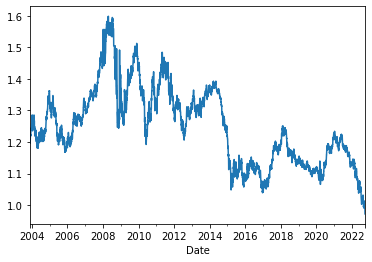

In [4]:
# Tend Plot of Data

y.plot()

In [5]:
# Recent view of Data

y.tail()

Date
2022-09-19    1.002235
2022-09-20    1.002959
2022-09-21    0.997079
2022-09-22    0.983072
2022-09-23    0.972101
Freq: D, Name: EURUSD=X, dtype: float64

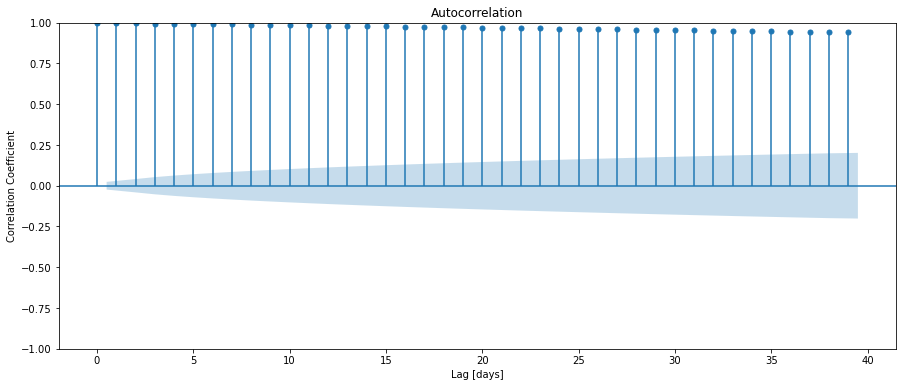

In [6]:
#ACF Plot

fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


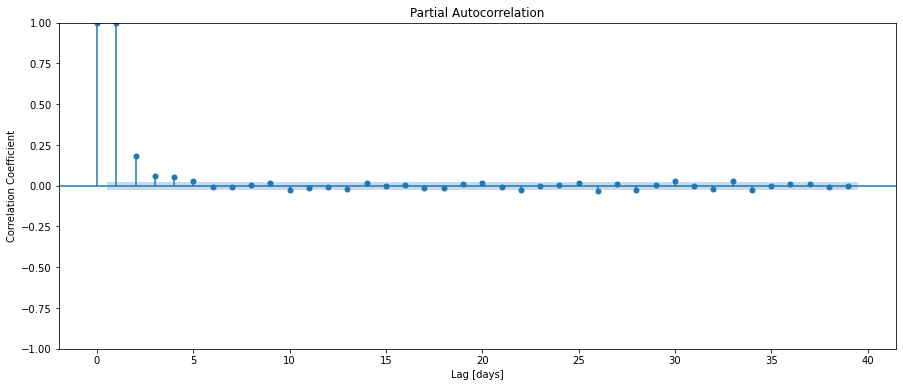

In [7]:
#PACF Plot

fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

In [8]:
# Splitting into trainong and testing data
cutoff_test = int(len(y) * 0.95)

y_train = y.iloc[:cutoff_test]
y_test = y.iloc[cutoff_test:]

In [9]:
y_train.shape

(6528,)

In [10]:
# Baseline Evaluation, using Mean Absolute Error

y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 1.26
Baseline MAE: 0.1


In [11]:
%%capture

# Walk forward validation
y_pred_wfv = pd.Series()
history = y_train
for i in range(len(y_test)):
    model = AutoReg(history, lags=1).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])

In [12]:
# Model Evaluation

test_mae = mean_absolute_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", test_mae)

Test MAE (walk forward validation): 0.0032656156364904852


In [13]:
# Walk forward validation forecasts as a DataFrame

df_pred_wfv_test = pd.DataFrame(
    {"y_test": y_test, "y_pred_wfv": y_pred_wfv}, index=y_test.index
)

df_pred_wfv_test.head()

,y_test,y_pred_wfv
Date,,
2021-10-15,1.159152,1.160183
2021-10-16,1.159152,1.159378
2021-10-17,1.159152,1.159378
2021-10-18,1.159703,1.159378
2021-10-19,1.161386,1.159928


<AxesSubplot:xlabel='Date'>

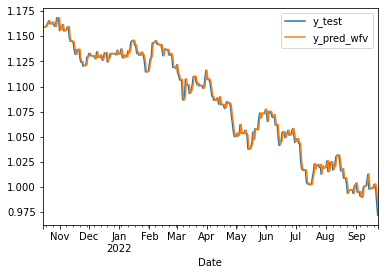

In [14]:
# Plot forecasted figures using walk forward validation against test data

df_pred_wfv_test.plot()

In [15]:
history.tail()

2022-09-19    1.002235
2022-09-20    1.002959
2022-09-21    0.997079
2022-09-22    0.983072
2022-09-23    0.972101
Freq: D, Name: EURUSD=X, dtype: float64

In [16]:
# Forecast for next period(Day)
model.forecast()

2022-09-23    0.983534
Freq: D, dtype: float64